# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

random.seed(42)
np.random.seed(42)

### **Задание 0**
Для чего фиксируем сиды в домашках?

Для того, чтобы результаты были воспроизводимыми при проверке.

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [3]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [4]:
df_train.to_csv('cars_train.csv', index=False)
df_test.to_csv('cars_test.csv', index=False)

### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [98]:
def show_null_columns(df, df_name):
    null_columns = df.isna().sum(axis=0)
    print(f'Columns with nulls in {df_name}:')
    for col in null_columns[null_columns > 0].index:
        print(col, null_columns[col])
    print()

show_null_columns(df_train, 'df_train')
show_null_columns(df_test, 'df_test')

Columns with nulls in df_train:
mileage 202
engine 202
max_power 196
torque 203
seats 202

Columns with nulls in df_test:
mileage 19
engine 19
max_power 19
torque 19
seats 19



In [99]:
def number_of_duplicates(df, df_name):
    print(f'Number of duplicated rows in {df_name}:', end=' ')
    print(df.duplicated().sum())

number_of_duplicates(df_train, 'df_train')
number_of_duplicates(df_test, 'df_test')

Number of duplicated rows in df_train: 985
Number of duplicated rows in df_test: 62


In [100]:
! pip install ydata-profiling -q

In [101]:
test = pd.DataFrame({'id': [0, 0, 1, 2, pd.NA, pd.NA]})

In [102]:
from ydata_profiling import ProfileReport

ProfileReport(df_train, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Выводы**

В числовых данных (seats, km_driven, таргет selling price) есть заметные выбросы в одну сторону (в большинстве случаев в сторону повышения), их гистограммы выглядят как сильно смещенные относительно центра. Возможно, данные придется чистить от выбросов. Может быть опасно использовать среднее для замены пропущенных значений.

Среди категориальных признаков распространено такое явление, что какое-то одно (owner, transmission, seller_type) или два (fuel) значения доминируют над другими.

km_driven и year могут оказаться переменными с самым большим вкладом – у них очень высокая корреляция с selling_price (у km_driven обратная). Т.к. они коррелируют друг с другом, и может оказаться, что кого-то придется выбросить для лучшей обусловленности.

В основном пропущены значения у переменных, отвечающих за технические детали машины (torque, engine, и т.п.), причем у одних и тех же. Возможно их нет, потому что их не указал продавец, и в этом случае само их отсутствие может быть признаком.

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [103]:
df_train.describe(include='number')

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [104]:
df_test.describe(include='number')

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

Между трэйном и тестом все 4 переменные более менее похожи. Внутри и трэйна и теста медиана заметно меньше среднего по km_driven и price. Вероятно это связано с наличием выбросов с завышением (это хорошо видно по гистограмме из отчета из предыдущего задания).

In [105]:
df_train.describe(include='object')

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

In [106]:
df_test.describe(include='object')

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [107]:
len(df_train[df_train.drop(['selling_price'], axis=1).duplicated()])

1159

In [108]:
df_train[df_train.drop(['selling_price'], axis=1).duplicated()]

name  year  selling_price  \
254                   Hyundai Grand i10 Sportz  2017         450000   
258                           Maruti Swift VXI  2012         330000   
268                     Maruti Swift Dzire VXI  2014         400000   
324   Jaguar XE 2016-2019 2.0L Diesel Prestige  2017        2625000   
325                              Lexus ES 300h  2019        5150000   
...                                        ...   ...            ...   
6947                    Chevrolet Spark 1.0 LS  2010         140000   
6984  Ford Freestyle Titanium Plus Diesel BSIV  2018         746000   
6989                    Maruti Swift Dzire VDI  2015         625000   
6997                           Tata Indigo CR4  2013         290000   
6998                           Tata Indigo CR4  2013         290000   

      km_driven    fuel seller_type transmission         owner     mileage  \
254       35000  Petrol  Individual       Manual   First Owner   18.9 kmpl   
258       50000  Petrol  Individual       Manual  Second Owner   18.6 kmpl   
268       70000  Petrol  Individual       Manual  Second Owner   19.1 kmpl   
324        9000  Diesel      Dealer    Automatic   First Owner   13.6 kmpl   
325       20000  Petrol      Dealer    Automatic   First Owner  22.37 kmpl   
...         ...     ...         ...          ...           ...         ...   
6947      60000  Petrol  Individual       Manual  Second Owner   18.0 kmpl   
6984      24000  Diesel  Individual       Manual   First Owner   24.4 kmpl   
6989      50000  Diesel  Individual       Manual   First Owner  26.59 kmpl   
6997      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   
6998      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   

       engine   max_power               torque  seats  
254   1197 CC      82 bhp       114Nm@ 4000rpm    5.0  
258   1197 CC    85.8 bhp       114Nm@ 4000rpm    5.0  
268   1197 CC    85.8 bhp       114Nm@ 4000rpm    5.0  
324   1999 CC     177 bhp  430Nm@ 1750-2500rpm    5.0  
325   2487 CC  214.56 bhp  202Nm@ 3600-5200rpm    5.0  
...       ...         ...                  ...    ...  
6947   995 CC      62 bhp      90.3Nm@ 4200rpm    5.0  
6984  1498 CC   98.63 bhp  215Nm@ 1750-3000rpm    5.0  
6989  1248 CC      74 bhp       190Nm@ 2000rpm    5.0  
6997  1396 CC      70 bhp  140Nm@ 1800-3000rpm    5.0  
6998  1396 CC      70 bhp  140Nm@ 1800-3000rpm    5.0  

[1159 rows x 13 columns]

In [109]:
df_train = df_train[~df_train.drop(['selling_price'], axis=1).duplicated()].reset_index(drop=True)

In [110]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

[Здесь](https://www.convertunits.com/from/N-m/to/kg-m) говорят, что в одном kgm 9.8 Nm.

In [111]:
import re
from sklearn.base import BaseEstimator, TransformerMixin

def torque_split(x):
    'tr'
    if pd.isna(x):
        return [np.nan, np.nan]

    x = x.replace(',', '')
    nums = re.compile(r'[\d\.]+').findall(x)
    nm = re.compile(r'[Nn]?[Mm]?').match(x)
    kgm = re.compile(r'kgm').match(x)

    assert 0 < len(nums) <= 3
    assert nm or kgm
    if len(nums) == 3:
        torque, max_rpm = float(nums[0]), float(nums[2])
    elif len(nums) == 2:
        torque, max_rpm = float(nums[0]), float(nums[1])
    elif len(nums) == 1:
        if nm or kgm:
            torque, max_rpm = float(nums[0]), np.nan
        else:
            torque, max_rpm = np.nan, float(nums[0])
    if kgm:
        torque *= 9.8
    return [torque, max_rpm]

class StringToNumericTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['engine'] = X['engine'].str.split().str[0].astype('float')
        X['max_power'] = X['max_power'].str.split().apply(lambda x: x[0] if isinstance(x, list) and len(x) == 2 else np.nan).astype('float')
        X['mileage'] = X['mileage'].str.split().str[0].astype('float')
        X['torque'], X['max_torque_rpm'] = zip(*X['torque'].apply(torque_split))
        return X

In [112]:
df_train = StringToNumericTransformer().fit_transform(df_train)
df_test = StringToNumericTransformer().fit_transform(df_test)

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [113]:
from sklearn.impute import SimpleImputer

numeric_imputer = SimpleImputer(strategy='median')
numeric_columns = df_train.drop(['selling_price'], axis=1).select_dtypes(include='number').columns

In [115]:
df_train[numeric_columns] = numeric_imputer.fit_transform(df_train[numeric_columns])
df_test[numeric_columns] = numeric_imputer.transform(df_test[numeric_columns])

In [116]:
df_train.isna().sum().sum()

0

In [117]:
df_test.isna().sum().sum()

0

Медиана для нас гораздо лучше среднего, так как на нее не оказывают влияния выбросы. Если бы мы заполняли средним, то наше распределение сдвинулось бы в сторону выбросов.

Считать медиану нужно только по train, т.к. в противном случае это была бы утечка данных из теста в обучающие данные. На практике мы можем вообще не знать тест.

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [118]:
class IntAssigner(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[['engine', 'seats']] = X[['engine', 'seats']].astype('int')
        return X

In [119]:
df_train = IntAssigner().fit_transform(df_train)
df_test = IntAssigner().fit_transform(df_test)

In [120]:
df_train['seats'].value_counts()

seats
5     4618
7      800
8      191
4       94
9       68
6       48
10      18
2        2
14       1
Name: count, dtype: int64

Видно, что различных значений seats очень немного, поэтому можно было бы использовать их как категориальные.

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [121]:
df_train.describe()

year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque        seats  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000     5840.000000  
mean     87.948422   161.309570     5.426712     3039.967123  
std      31.577884    91.174286     0.982344      916.326648  
min      32.800000     4.800000     2.000000      500.000000  
25%      68.000000    99.040000     5.000000     2250.000000  
50%      81.860000   150.000000     5.000000     3000.000000  
75%      99.000000   200.000000     5.000000     4000.000000  
max     400.000000   789.000000    14.000000    21800.000000

In [122]:
df_test.describe()

year  selling_price      km_driven     mileage      engine  \
count  1000.000000   1.000000e+03    1000.000000  1000.00000  1000.00000   
mean   2013.681000   6.179010e+05   71393.341000    19.33881  1454.87600   
std       4.012149   7.585539e+05   48486.218662     3.95175   521.99574   
min    1995.000000   3.100000e+04    1303.000000     0.00000   624.00000   
25%    2011.000000   2.500000e+05   37000.000000    16.55000  1197.00000   
50%    2014.000000   4.349990e+05   61500.000000    19.37000  1248.00000   
75%    2017.000000   6.700000e+05  100000.000000    22.30000  1582.00000   
max    2020.000000   6.000000e+06  375000.000000    32.26000  3604.00000   

         max_power       torque        seats  max_torque_rpm  
count  1000.000000  1000.000000  1000.000000     1000.000000  
mean     90.841670   165.711010     5.403000     3088.776000  
std      34.893389    95.142648     0.912921      887.655682  
min      34.200000     6.100000     4.000000      500.000000  
25%      69.000000    99.040000     5.000000     2500.000000  
50%      82.425000   150.000000     5.000000     3000.000000  
75%     102.000000   200.500000     5.000000     4000.000000  
max     280.000000   620.000000     9.000000     5200.000000

Только распределение km_driven заметно поменялось (медиана была 60000, стала 70000 на трейне), но это, видимо, из-за дубликатов, пропущенных значений там не было. В остальном никаких изменений, которые можно было бы заметить. Небольшое изменение распределения, конечно, возникло (условно, в области медианы значение стало иметь чуть больший вес), но нет оснований считать, что это повлияет на наши результаты.

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

Шаг 1.

На многих графиках есть точки имеют форму треугольника, например, между km_driven и selling_price: это значит, что при высокая цена означает низкие значения km_driven, а низкая цена встречается и с низкими, и с высокими значениями. Подобный график говорит о корреляции: мы видим что-то подобное, например, между selling_price и torque, max_power, engine, seats, mileage (у последнего наименее ярко). Такую зависимость, хоть она и не линейная, очевидно можно приблизить линейной: вероятно, график зависимости может оказаться похож на медиану, и у одного из углов треугольника отклонение будет совсем маленьким и постепенно увеличиваться ближе к противоположной стороне.

Между признаками есть и более сильные примеры. Например, между max_power и engine, max_power и torque зависимость похожа на линейную, между max_power и mileage точки распределены в форме треугольника.

Признак max_torque_rpm как будто вообще ни с кем не коррелирует.

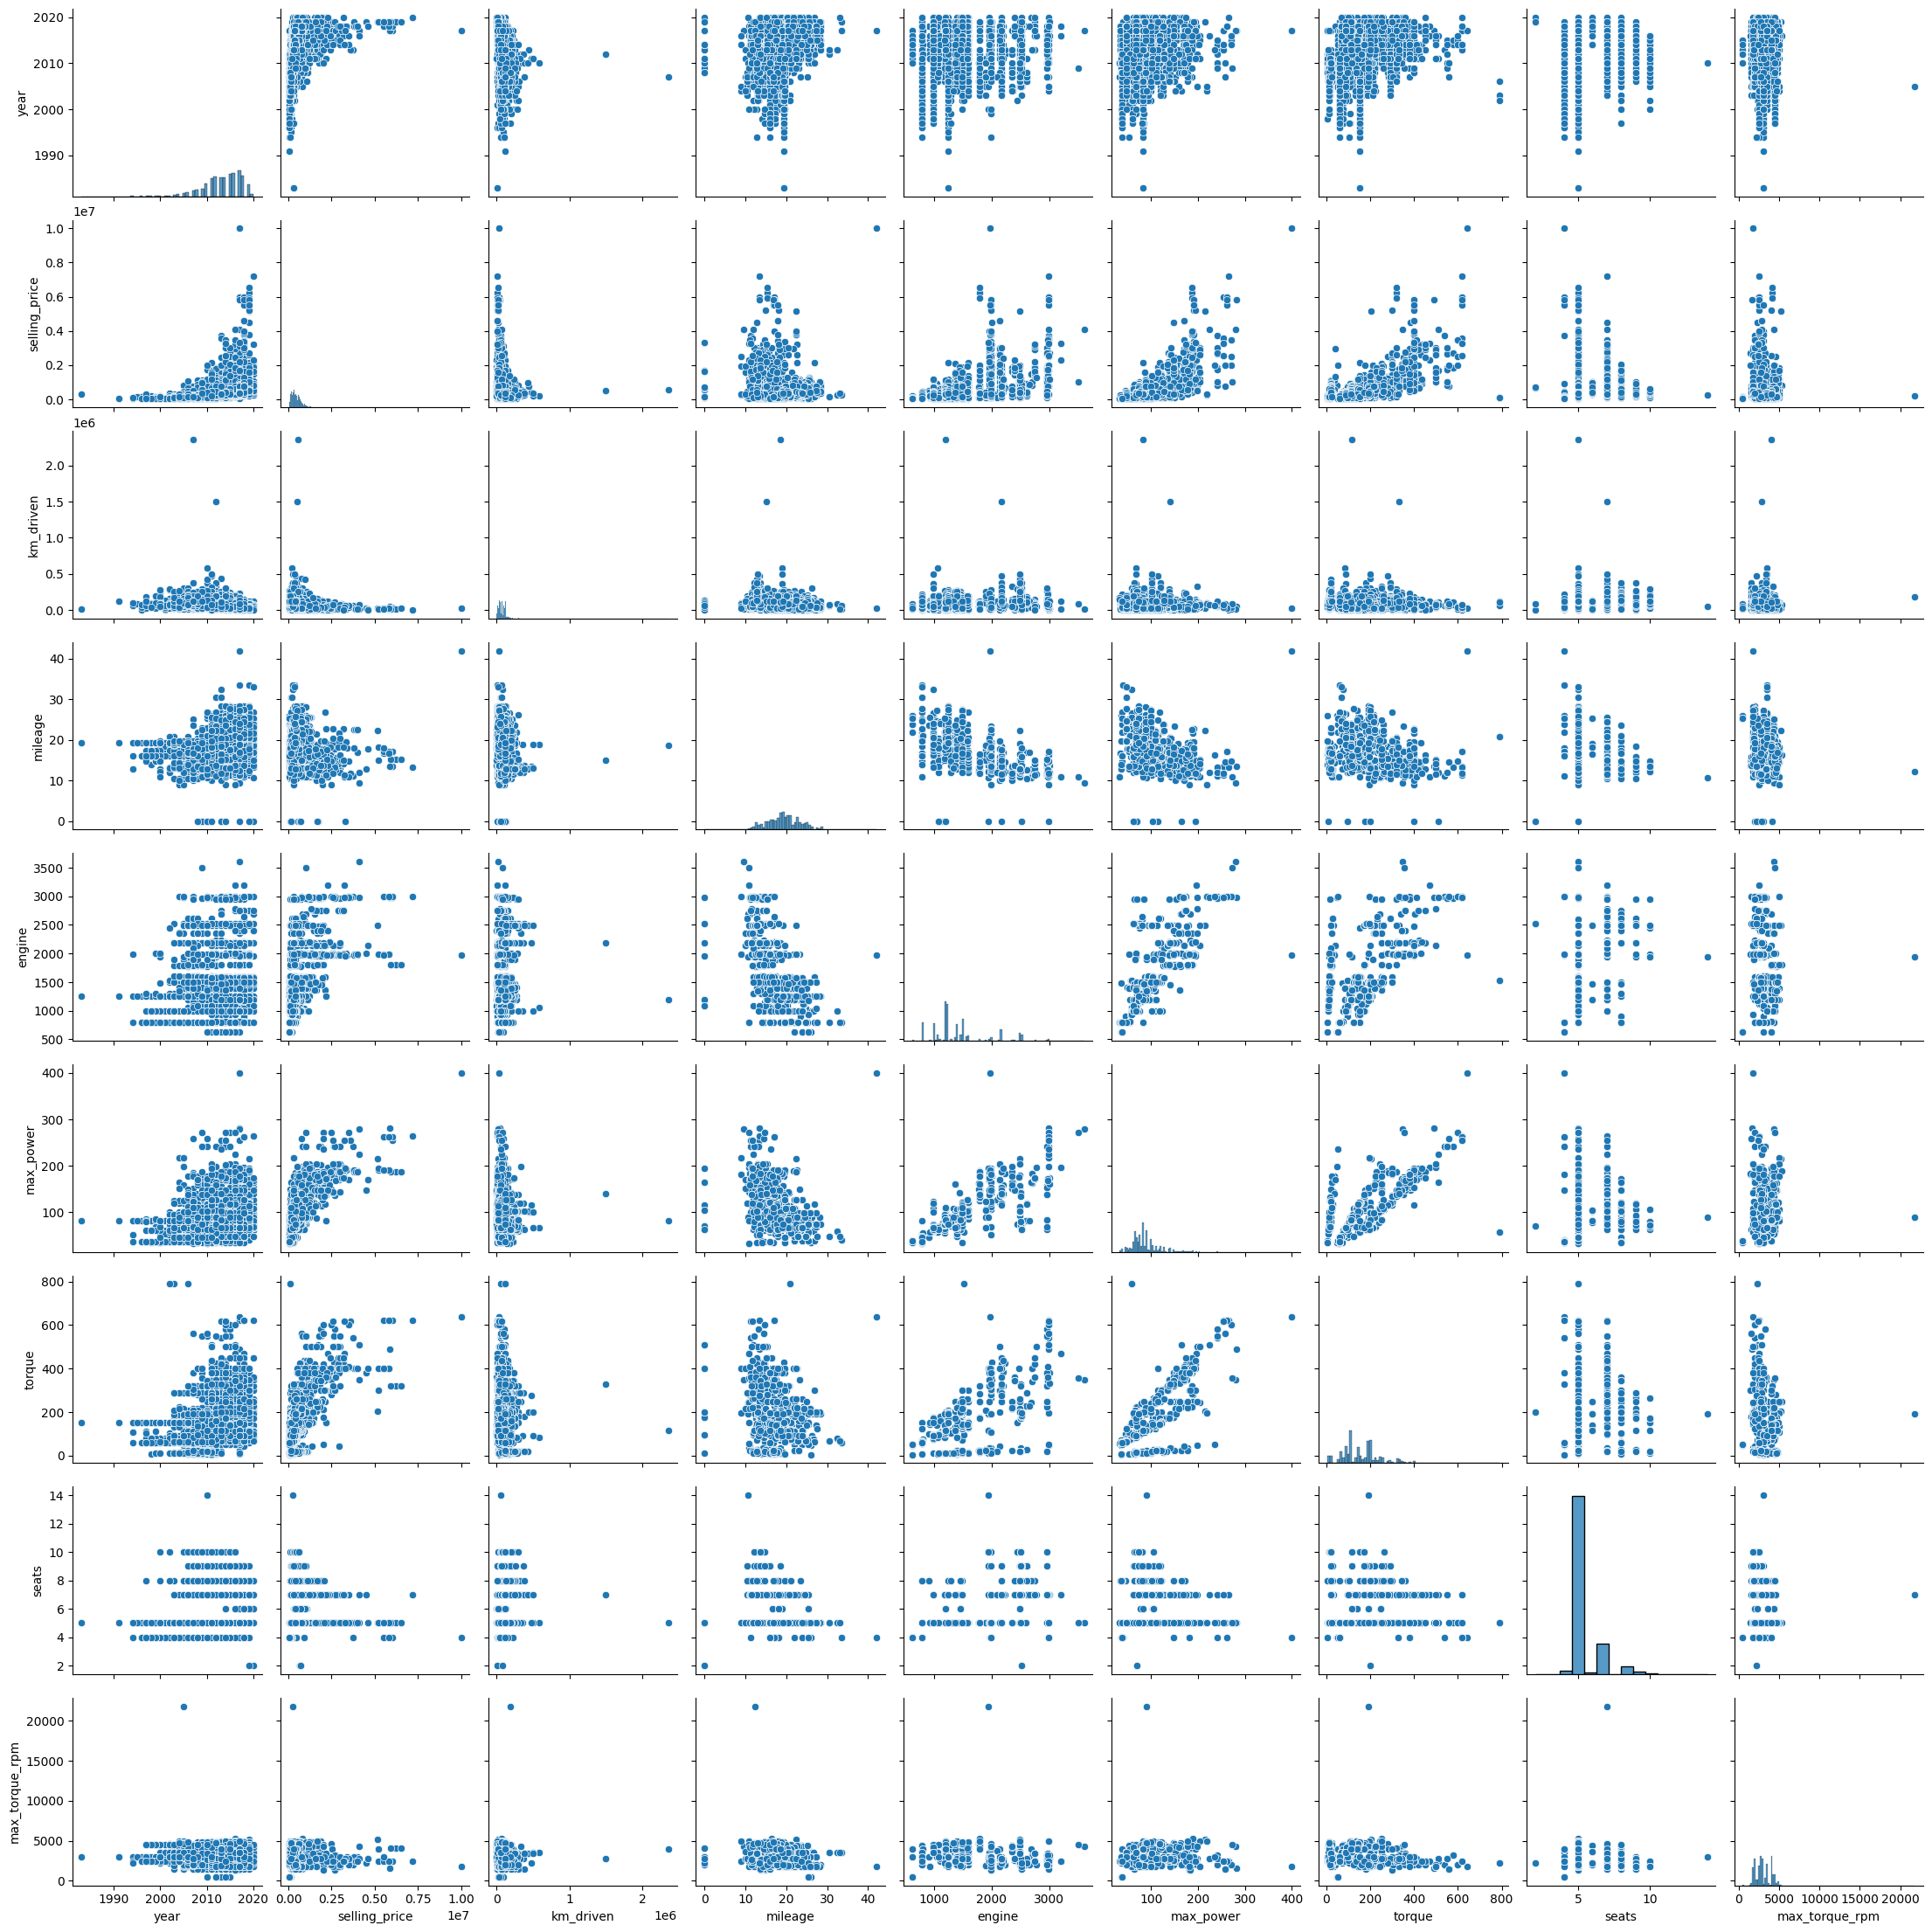

In [123]:
sns.pairplot(df_train.select_dtypes(include='number'))

Шаг 2. В целом есть ощущение, что графики, которые я отметил на предыдущем шаге, в основном похожи: те же треугольники, есть парочка линейных зависимостей. Видно, что гораздо меньше выбросов (особенно заметно на примере max_torque_rpm, который на трейне узкий прямоугольник, а здесь размазан практически по всему квадрату).

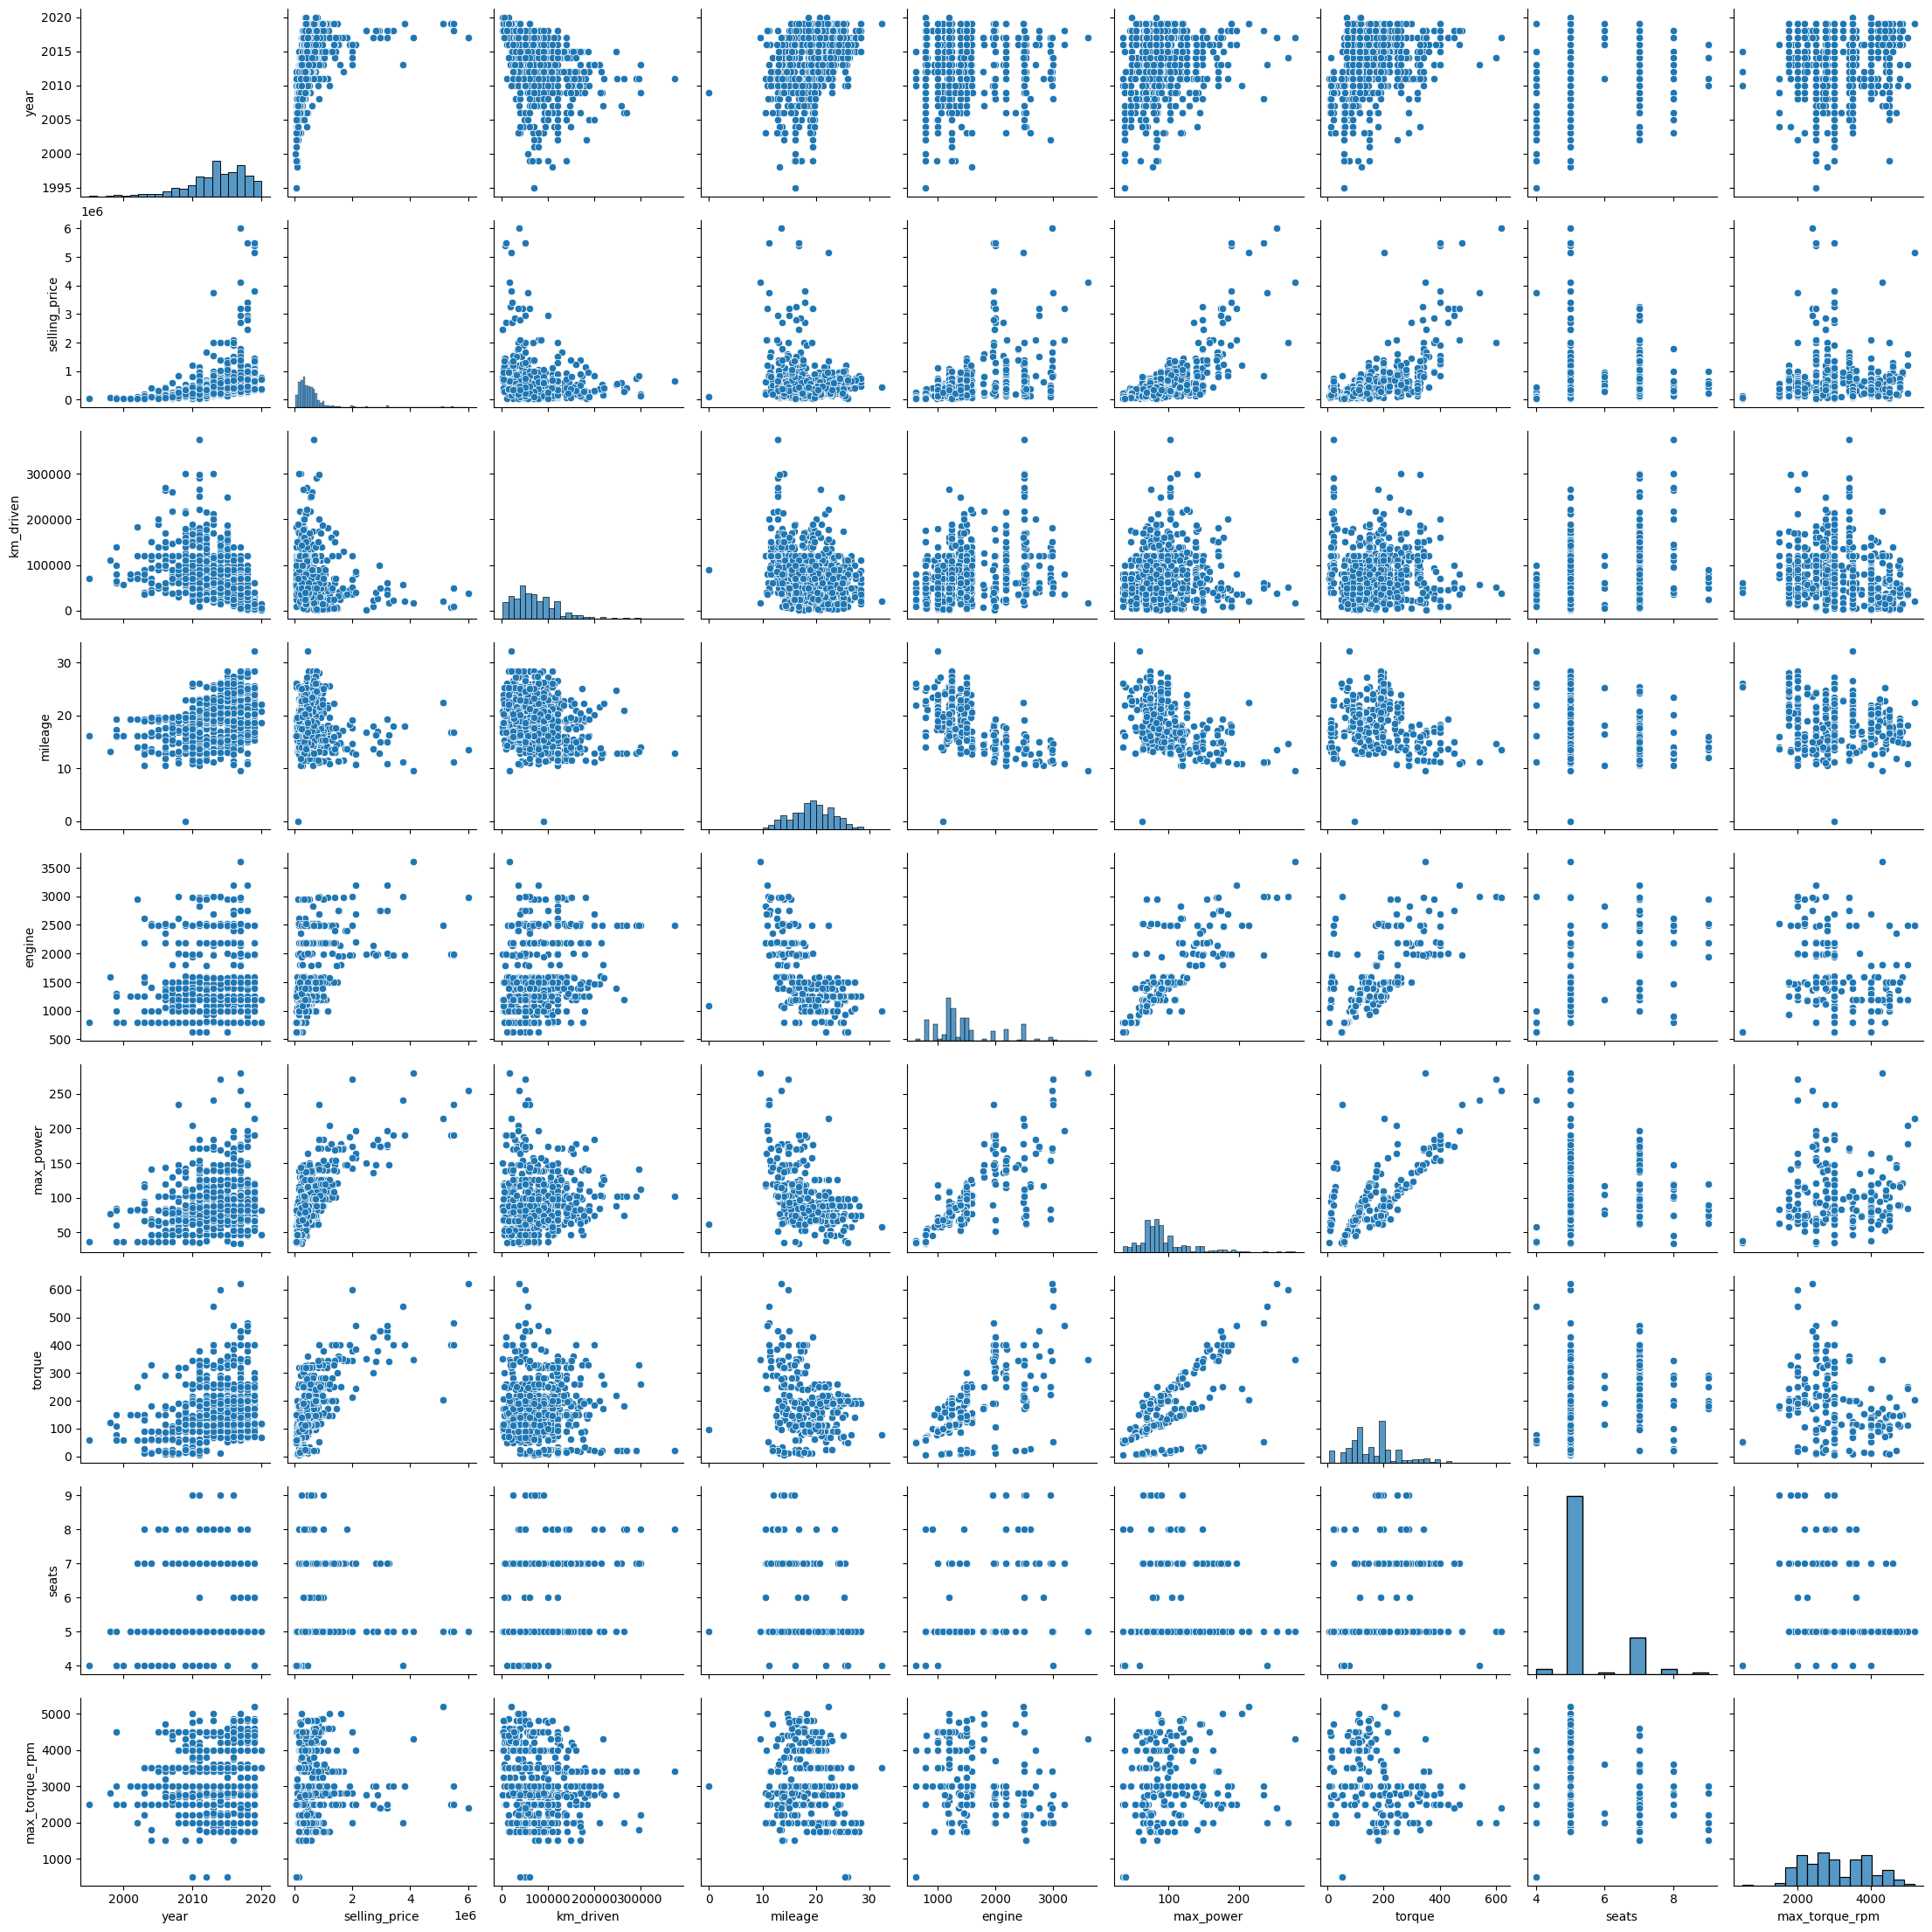

In [124]:
sns.pairplot(df_test.select_dtypes(include='number'))

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [125]:
df_train_corr = df_train.select_dtypes(include='number').corr()

<Axes: >

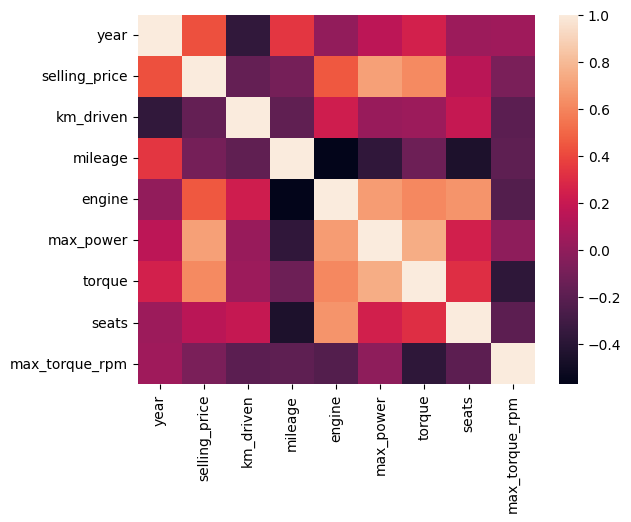

In [126]:
sns.heatmap(df_train_corr)

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

Меньше всего скоррелированы engine и year.

Сильная положительная зависимость между max_power и torque.

Утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи, можно – между ними одна корреляция из самыз больших по модулю отрицательных корреляций.

In [127]:
df_train_corr.abs().min()

year              0.002819
selling_price     0.082284
km_driven         0.024539
mileage           0.104769
engine            0.002819
max_power         0.009805
torque            0.039362
seats             0.041178
max_torque_rpm    0.009805
dtype: float64

In [128]:
df_train_corr.replace(1, 0).max()

year              0.427279
selling_price     0.693742
km_driven         0.229766
mileage           0.341334
engine            0.681968
max_power         0.745962
torque            0.745962
seats             0.652172
max_torque_rpm    0.049746
dtype: float64

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [129]:
def convert_to_df(func):
    def wrapper(A):
        return pd.DataFrame(func(A), index=A.columns, columns=A.columns)
    return wrapper

In [130]:
# моя реализация
@convert_to_df
def spearman_corr(A):
    rank_A = np.argsort(np.argsort(A, axis=0), axis=0) + 1

    n, m = A.shape

    spearman = np.zeros((m, m))
    for i in range(m):
        for j in range(i, m):
            rank_x = rank_A[:, i]
            rank_y = rank_A[:, j]

            spearman[i, j] = 1 - (6 * np.sum((rank_x - rank_y) ** 2)) / (n * (n ** 2 - 1))
            spearman[j, i] = spearman[i, j]

    return spearman

In [131]:
spearman_corr_mine = spearman_corr(df_train.select_dtypes(include='number'))

In [132]:
# реализация из библиотеки
spearman_corr_pd = df_train.select_dtypes(include='number').corr(method='spearman')

Моя реализация отличается тем, что не делает усреднение рангов для одинаковых значений. Тем не менее, видно, что значения относительно похожи для большинства признаков (исключение – seats, где одинаковых значений много).

В целом, эта корреляция считает обычную корреляцию, но не для самих значений, а для их порядковых номеров. Т.е. она как бы проверяет: если одно значение больше другого в одном столбце, верно ли это для другого столбца. Ясно, что это может помочь отследить любые **монотонные** зависимости, а не только линейные.

На хитмапах ниже видно, что некоторые корреляции стали еще заметнее (больше по модулю; между year и selling_price, year и km_driven, например), но по сути ничего не изменилось.

<Axes: >

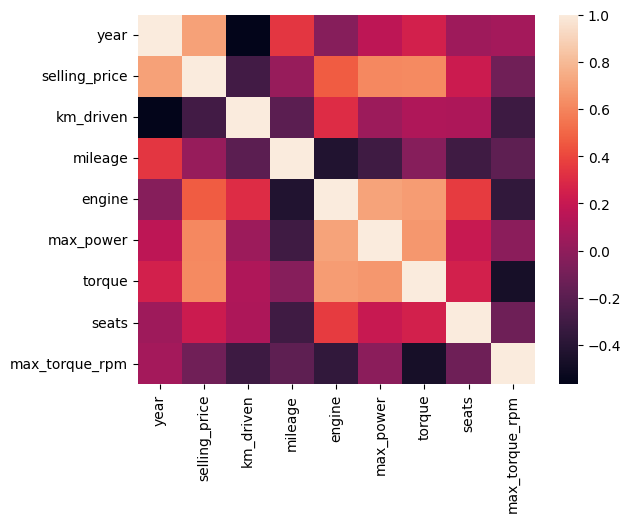

In [133]:
sns.heatmap(spearman_corr_mine)

<Axes: >

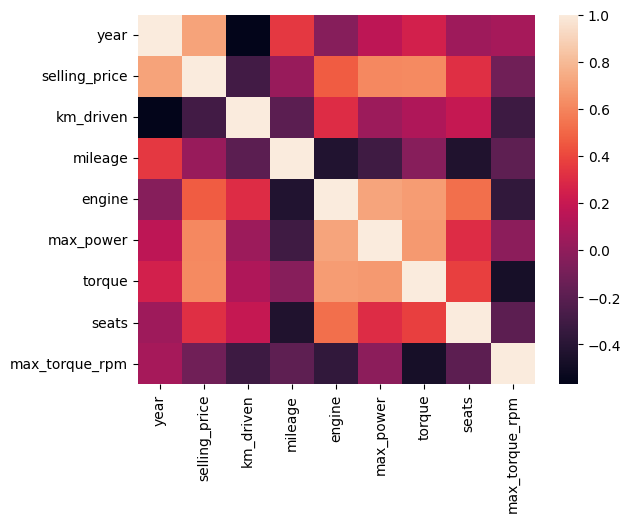

In [134]:
sns.heatmap(spearman_corr_pd)

In [135]:
! pip install phik -q

In [136]:
import phik

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


<Axes: >

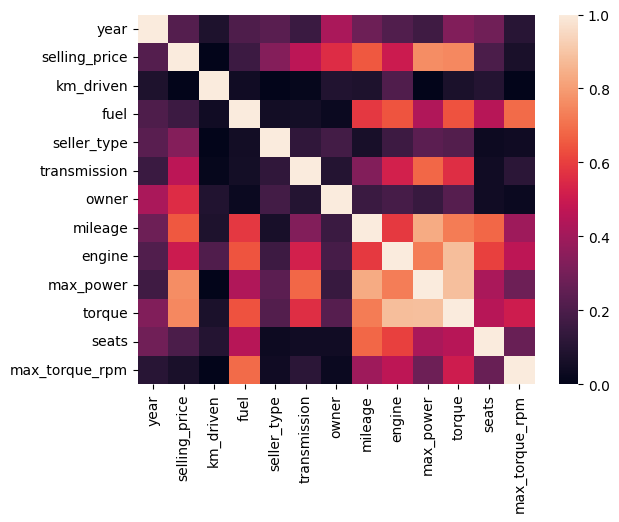

In [137]:
phik_corr = df_train.drop('name', axis=1).phik_matrix()
sns.heatmap(phik_corr)

phik можно применять к категориальным столбцам (я все равно убрал name, т.к. мы в будущем его будем предобрабатывать, а сейчас он не очень информативен); насколько я понимаю, численные столбцы он также делает "категориальными", разбивая на отрезки.

Видно, что transmission и fuel type коррелируют с разными числовыми параметрами двигателя. owner чуть чуть коррелирует с ценой. При этом phik довольно плохо уловил некоторые зависимости, которые мы уже обнаружили (например, между year, km_driven и selling_price).

`Your answer here`

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

In [49]:
# your code here

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [138]:
df_num_train = df_train.select_dtypes(include='number')
df_num_test = df_test.select_dtypes(include='number')

In [139]:
y_train = df_num_train['selling_price']
X_train = df_num_train.drop('selling_price', axis=1)

In [140]:
'''
у нас очевидно 8 столбцов:
про year и seats никто не говорил, что его надо считать категориальным
km_driven, mileage, engine, max_power, torque, max_torque_rpm очевидно числовые
'''
# assert X_train.shape == (5840, 6)
assert X_train.shape == (5840, 8)

In [141]:
y_test = df_num_test['selling_price']
X_test = df_num_test.drop('selling_price', axis=1)

In [142]:
'''
у нас очевидно 8 столбцов:
про year и seats никто не говорил, что его надо считать категориальным
km_driven, mileage, engine, max_power, torque, max_torque_rpm очевидно числовые
'''
# assert X_test.shape == (1000, 6)
assert X_test.shape == (1000, 8)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred_default = model.predict(X_train)
y_test_pred_default = model.predict(X_test)

In [144]:
def print_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print('R^2 train: ', r2_score(y_train, y_train_pred))
    print('MSE train: ', MSE(y_train, y_train_pred))
    print('R^2 test: ', r2_score(y_test, y_test_pred))
    print('MSE test: ', MSE(y_test, y_test_pred))

In [145]:
print_metrics(y_train, y_train_pred_default, y_test, y_test_pred_default)

R^2 train:  0.6035480484016411
MSE train:  113638328644.89487
R^2 test:  0.602186681640248
MSE test:  228674455206.47287


### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [146]:
def r2_score_mine(y_true, y_pred):
    y_bar = y_true.mean()
    return 1 - ((y_true - y_pred) ** 2).sum() / ((y_true - y_bar) ** 2).sum()

In [147]:
r2_score_mine(y_train, y_train_pred_default) == r2_score(y_train, y_train_pred_default)

True

$R^2 = (1 - \frac{\sum(y_{true} - y_{pred})^2}{\sum(y_{true} - \bar y)^2})$

$y_{true}$ – правильные ответы; $y_{pred}$ – предсказанные моделью ответы; $\bar y$ – усредненные $y_{true}$.

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [148]:
def r2_score_adjusted(X_train, y_true, y_pred):
    # n is number of data points
    # p is number of features
    n = X_train.shape[0]
    p = X_train.shape[1]
    return 1 - (1 - r2_score_mine(y_true, y_pred)) * ((n - 1) / (n - p - 1))

In [152]:
r2_score_adjusted(X_train, y_train, y_train_pred_default), r2_score_adjusted(X_train, y_test, y_test_pred_default)

(0.6030041252987794, 0.6016408907730078)

Идея в том, что когда появляются новые признаки, которые не улучшают модель, R^2 не меняется, а R^2 adjusted становится меньше, т.к. увеличивается параметр p из имплементации выше. Для минимизации R^2 adjusted мы заинтересованы не только в лучшей модели по качеству, но и в минимальном количестве признаков. Таким образом, R^2 adjusted можно использовать для поиска наиболее сбалансированной модели с точки зрения качества и вычислительной сложности.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [153]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [154]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_train_pred_scaled_default = model.predict(X_train_scaled)
y_test_pred_scaled_default = model.predict(X_test_scaled)

In [155]:
print_metrics(y_train, y_train_pred_scaled_default, y_test, y_test_pred_scaled_default)

R^2 train:  0.6035480484016412
MSE train:  113638328644.89482
R^2 test:  0.6021866816402525
MSE test:  228674455206.4703


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [156]:
X_train.columns[np.argmax(np.abs(model.coef_))]

'max_power'

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [157]:
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(X_train_scaled, y_train)
y_train_pred_lasso_default = model.predict(X_train_scaled)
y_test_pred_lasso_default = model.predict(X_test_scaled)
print_metrics(y_train, y_train_pred_lasso_default, y_test, y_test_pred_lasso_default)

R^2 train:  0.6035480483534699
MSE train:  113638328658.70259
R^2 test:  0.602185384981192
MSE test:  228675200563.1252


In [158]:
model.coef_

array([160349.24459608, -48138.94582358, -11336.75358577,  18709.39903536,
       308897.23453402,  38361.56364672, -31070.62119603, -48018.68041315])

Никакие коэффициэнты модель не занулила. Вероятно, это связано с тем, что у нас просто нет совсем не связанных с целевой переменной столбцов. Это можно видеть и по матрице корреляции: самое маленькое по модулю значение 0.08, что не так уж и мало, не близко к нулю. Этот признак несет мало информации, но не так мало, чтобы его было осмысленно занулить.

In [159]:
df_train_corr['selling_price'].abs().min()

0.08228355227346416

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [160]:
from sklearn.model_selection import GridSearchCV

In [161]:
cv = GridSearchCV(
    Lasso(),
    param_grid={
        'alpha': np.logspace(-2, 4, 50),
        'max_iter': [1000, 2000, 3000],
        'tol': [1e-4, 1e-3, 1e-2]
    },
    cv=5,
    scoring='neg_mean_squared_error'
)

In [162]:
cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-02, 1.32571137e-02, 1.75751062e-02, 2.32995181e-02,
       3.08884360e-02, 4.09491506e-02, 5.42867544e-02, 7.19685673e-02,
       9.54095476e-02, 1.26485522e-01, 1.67683294e-01, 2.22299648e-01,
       2.94705170e-01, 3.90693994e-01, 5.17947468e-01, 6.86648845e-01,
       9.10298178e-01, 1.20679264e+00, 1.59985872e+00, 2....
       8.28642773e+01, 1.09854114e+02, 1.45634848e+02, 1.93069773e+02,
       2.55954792e+02, 3.39322177e+02, 4.49843267e+02, 5.96362332e+02,
       7.90604321e+02, 1.04811313e+03, 1.38949549e+03, 1.84206997e+03,
       2.44205309e+03, 3.23745754e+03, 4.29193426e+03, 5.68986603e+03,
       7.54312006e+03, 1.00000000e+04]),
                         'max_iter': [1000, 2000, 3000],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='neg_mean_squared_error')

In [163]:
best_model = cv.best_estimator_
print("Best Parameters:", cv.best_params_)

Best Parameters: {'alpha': 4291.934260128778, 'max_iter': 1000, 'tol': 0.01}


In [164]:
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

R^2 train:  0.6028901852035333
MSE train:  113826897458.8673
R^2 test:  0.5965818441486839
MSE test:  231896275846.33688


In [165]:
best_model.coef_

array([151854.07866172, -44665.10288408,     -0.        ,  13443.86884818,
       308590.82672741,  40899.40208778, -17250.73575725, -38029.17029291])

In [166]:
best_model.intercept_

522960.0910958868

In [167]:
X_train.columns[np.argwhere(best_model.coef_ == 0).item()]

'mileage'

**Ответы**

GridSearch обучил $50 * 3 * 3 * 5 = 2250$ моделей: 50 значений для alpha, 3 значения max_iter, 3 значения tol;  всего $50 * 3 * 3$ набора параметров; для каждого набора параметров выборка была разбита на 5 фолдов (параметр cv) и модель обучена 5 раз (на каждом она обучалась на всех фолдах, кроме одного, и тестировалась на оставшемся).

alpha – коэффициэнт регуляризации; max_iter и tol – число итераций и ограничение на критерий останова для алгоритма оптимизации внутри Lasso (видимо, форма градиентного спуска).

У лучшей модели alpha = 4291. Вес при mileage при этом занулился.

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [168]:
from sklearn.linear_model import ElasticNet

In [169]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

ElasticNet часто не сходится, даже если поставить огромное число итераций (десятки тысяч шагов), несмотря на то, что мы используем отмасштабированные данные. При этом этого ворнинга нет с дефолтными параметрами, поэтому я решил просто отключить его.

In [170]:
cv = GridSearchCV(
    ElasticNet(),
    param_grid={
        'alpha': np.logspace(-2, 4, 50),
        'l1_ratio': np.linspace(0, 1, 11),
        'max_iter': [1000, 2000, 3000],
        'tol': [1e-4, 1e-3, 1e-2]
    },
    cv=5,
    scoring='neg_mean_squared_error'
)

cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-02, 1.32571137e-02, 1.75751062e-02, 2.32995181e-02,
       3.08884360e-02, 4.09491506e-02, 5.42867544e-02, 7.19685673e-02,
       9.54095476e-02, 1.26485522e-01, 1.67683294e-01, 2.22299648e-01,
       2.94705170e-01, 3.90693994e-01, 5.17947468e-01, 6.86648845e-01,
       9.10298178e-01, 1.20679264e+00, 1.59985872e+...
       2.55954792e+02, 3.39322177e+02, 4.49843267e+02, 5.96362332e+02,
       7.90604321e+02, 1.04811313e+03, 1.38949549e+03, 1.84206997e+03,
       2.44205309e+03, 3.23745754e+03, 4.29193426e+03, 5.68986603e+03,
       7.54312006e+03, 1.00000000e+04]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_iter': [1000, 2000, 3000],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='neg_mean_squared_error')

In [171]:
best_model = cv.best_estimator_
print("Best Parameters:", cv.best_params_)

y_train_pred_num_features = best_model.predict(X_train_scaled)
y_test_pred_num_features = best_model.predict(X_test_scaled)
print_metrics(y_train, y_train_pred_num_features, y_test, y_test_pred_num_features)

Best Parameters: {'alpha': 4291.934260128778, 'l1_ratio': 1.0, 'max_iter': 1000, 'tol': 0.01}
R^2 train:  0.6028901852035333
MSE train:  113826897458.8673
R^2 test:  0.5965818441486839
MSE test:  231896275846.33688


Ответы:

Обучилось $2250 * 11 = 24750$ моделей: добавился еще один параметр l1_ratio с 11 вариантами.

Лучшей моделью оказалась Lasso регрессия из предыдущего шага.

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



По сути L0 можно получить так: обучить простую линейную регрессию на всех возможных наборах признаков и прибавить к каждой штраф – число признаков, умноженное на коэффициэнт регуляризации.

In [172]:
from itertools import combinations

class L0LinearRegression(LinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.best_comb = None
        self.metric_value = None

    def fit(self, X, y):
        self.best_comb = None
        self.metric_value = None

        X = np.array(X)
        total_features = X.shape[1]

        for num_features in range(1, total_features + 1):
            for comb in combinations(range(total_features), num_features):
                X_subset = X[:, comb]
                super().fit(X_subset, y)
                y_pred = super().predict(X_subset)
                # нет нужды проверять нулевые веса
                # потому что мы все равно проверим соответствующую комбинацию
                curr_metric_value = MSE(y, y_pred) + self.alpha * len(comb)
                if self.metric_value is None or curr_metric_value < self.metric_value:
                    self.best_comb = comb
                    self.metric_value = curr_metric_value

        super().fit(X[:, self.best_comb], y)
        return self

In [173]:
model = L0LinearRegression()

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

R^2 train:  0.6035480484016412
MSE train:  113638328644.89482
R^2 test:  0.6021866816402525
MSE test:  228674455206.4703


In [174]:
cv = GridSearchCV(
    L0LinearRegression(),
    param_grid={
        # возьмем поменьше параметров
        # иначе слишком долго
        'alpha': np.logspace(-2, 4, 20),
    },
    cv=5,
    scoring='neg_mean_squared_error'
)

cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=L0LinearRegression(),
             param_grid={'alpha': array([1.00000000e-02, 2.06913808e-02, 4.28133240e-02, 8.85866790e-02,
       1.83298071e-01, 3.79269019e-01, 7.84759970e-01, 1.62377674e+00,
       3.35981829e+00, 6.95192796e+00, 1.43844989e+01, 2.97635144e+01,
       6.15848211e+01, 1.27427499e+02, 2.63665090e+02, 5.45559478e+02,
       1.12883789e+03, 2.33572147e+03, 4.83293024e+03, 1.00000000e+04])},
             scoring='neg_mean_squared_error')

In [175]:
best_model = cv.best_estimator_
print("Best Parameters:", cv.best_params_)

y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Best Parameters: {'alpha': 0.01}
R^2 train:  0.6035480484016412
MSE train:  113638328644.89482
R^2 test:  0.6021866816402525
MSE test:  228674455206.4703


In [176]:
len(best_model.best_comb)

8

Попытка применить L0 приводит к тому, что коэффициэнт регуляризации выбирается самый маленький, и берутся все признаки, иными словами, регуляризация вообще не используется. Мы уже замечали, что у нас нет прямо совсем бесполезных признаков, Lasso смог занулить один признак только с гигантской альфа, в данном случае наблюдается аналогичная ситуация.

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [177]:
df_train['name']

0                  Maruti Swift Dzire VDI
1            Skoda Rapid 1.5 TDI Ambition
2               Hyundai i20 Sportz Diesel
3                  Maruti Swift VXI BSIII
4           Hyundai Xcent 1.2 VTVT E Plus
                      ...                
5835              Hyundai Santro Xing GLS
5836    Maruti Wagon R VXI BS IV with ABS
5837                    Hyundai i20 Magna
5838                Hyundai Verna CRDi SX
5839               Maruti Swift Dzire ZDi
Name: name, Length: 5840, dtype: object

Очевидно, что в name первое слово – всегда марка машины, а дальше идет конкретная модель; конкретных моделей, вероятно, слишком много, возьмем только марку.

In [178]:
class NameExtractor(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['name'] = X['name'].str.split().str[0]
        return X

In [179]:
df_train = NameExtractor().transform(df_train)
df_test = NameExtractor().transform(df_test)

In [180]:
 X_train_cat = df_train.drop(['selling_price'], axis=1)

In [181]:
# assert X_train_cat.shape == (5840, 11)
assert X_train_cat.shape == (5840, 13)

In [182]:
X_train_cat.describe(include='object')

name    fuel seller_type transmission        owner
count     5840    5840        5840         5840         5840
unique      30       4           3            2            5
top     Maruti  Diesel  Individual       Manual  First Owner
freq      1804    3177        5223         5336         3603

In [183]:
X_test_cat = df_test.drop(['selling_price'], axis=1)

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [184]:
# еще один imputer для будущего fastapi сервиса, на случай
# если nan появятся в новых данных
categorical_columns = X_train_cat.select_dtypes(include='object').columns
categorical_imputer = SimpleImputer(strategy='most_frequent').fit(X_train_cat[categorical_columns])

In [185]:
from sklearn.preprocessing import OneHotEncoder

In [211]:
encoding_scaling_ct = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_columns),
    ('encoding', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])

In [212]:
encoding_scaling_ct.fit(X_train_cat)

ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                 Index(['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'seats', 'max_torque_rpm'],
      dtype='object')),
                                ('encoding',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 Index(['name', 'fuel', 'seller_type', 'transmission', 'owner'], dtype='object'))])

In [220]:
X_train_proper = encoding_scaling_ct.transform(X_train_cat).toarray()
X_test_proper = encoding_scaling_ct.transform(X_test_cat).toarray()

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?


1.   Помимо того, что упомянуто ниже: OHE столбцы нет нужды стандартизировать; нужно следить, что категорий не слишком много.
2.   Один столбец нужно удалить, чтобы не было линейной зависимости. Если добавить все столбцы, то один из них можно получить из остальных столбцов и единичного (байеса).
3. Это некорректно. В пункте 2 мы обсудили, что одну из категорий мы должны удалить. Если мы удалим еще одну, то с точки зрения модели это как если бы на этом месте была первая удаленная категория. Но может быть, первая удаленная как раз очень важна для модели, просто модель узнает о ней исходя из всех остальных.Речь должна идти о релевантности всего категориального признака в целом.



### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [221]:
from sklearn.linear_model import Ridge

cv = GridSearchCV(
    Ridge(),
    param_grid={
        'alpha': np.logspace(-2, 4, 50),
    },
    cv=10,
    scoring='r2'
)

cv.fit(X_train_proper, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-02, 1.32571137e-02, 1.75751062e-02, 2.32995181e-02,
       3.08884360e-02, 4.09491506e-02, 5.42867544e-02, 7.19685673e-02,
       9.54095476e-02, 1.26485522e-01, 1.67683294e-01, 2.22299648e-01,
       2.94705170e-01, 3.90693994e-01, 5.17947468e-01, 6.86648845e-01,
       9.10298178e-01, 1.20679264e+00, 1.59985872e+00, 2...
       8.68511374e+00, 1.15139540e+01, 1.52641797e+01, 2.02358965e+01,
       2.68269580e+01, 3.55648031e+01, 4.71486636e+01, 6.25055193e+01,
       8.28642773e+01, 1.09854114e+02, 1.45634848e+02, 1.93069773e+02,
       2.55954792e+02, 3.39322177e+02, 4.49843267e+02, 5.96362332e+02,
       7.90604321e+02, 1.04811313e+03, 1.38949549e+03, 1.84206997e+03,
       2.44205309e+03, 3.23745754e+03, 4.29193426e+03, 5.68986603e+03,
       7.54312006e+03, 1.00000000e+04])},
             scoring='r2')

In [222]:
best_model = cv.best_estimator_
print("Best Parameters:", cv.best_params_)

y_train_pred_all_features = best_model.predict(X_train_proper)
y_test_pred_all_features = best_model.predict(X_test_proper)
print_metrics(y_train, y_train_pred_all_features, y_test, y_test_pred_all_features)

Best Parameters: {'alpha': 2.1209508879201904}
R^2 train:  0.7615100282911353
MSE train:  68360369205.64835
R^2 test:  0.7760132674047101
MSE test:  128753969979.92494


Качество прогнозов заметно улучшилось (раньше R^2 было порядка 0.6, теперь 0.75+). Это первый раз, когда произошло такое улучшение.

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [ ]:
# your code here

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [189]:
def business_metrics(y_true, y_pred):
    return np.mean((y_pred <= 1.1 * y_true) & (y_pred >= 0.9 * y_true))

In [190]:
# Модель из задания 12
print(business_metrics(y_test, y_test_pred_default))
# Из задания 14
print(business_metrics(y_test, y_test_pred_scaled_default))
# 16
print(business_metrics(y_test, y_test_pred_lasso_default))
# 17
print(business_metrics(y_test, y_test_pred_num_features))
# 22
print(business_metrics(y_test, y_test_pred_all_features))

0.248
0.248
0.248
0.24
0.282


Лучше всего, естественно, решает последняя, обученная на всех признаках.

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [191]:
def your_business_metrics(y_true, y_pred):
    return None


In [192]:
# Модель из задания 12
print(your_business_metrics(y_test, y_test_pred_default))
# Из задания 14
print(your_business_metrics(y_test, y_test_pred_scaled_default))
# 16
print(your_business_metrics(y_test, y_test_pred_lasso_default))
# 17
print(your_business_metrics(y_test, y_test_pred_num_features))
# 22
print(your_business_metrics(y_test, y_test_pred_all_features))

None
None
None
None
None


# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

#### Сохранение пайплайна

In [196]:
class CustomImputer(TransformerMixin):
    def __init__(self, numeric_imputer, categorical_imputer,
                 numeric_columns, categorical_columns):
        self.numeric_imputer = numeric_imputer
        self.categorical_imputer = categorical_imputer
        self.numeric_columns = numeric_columns
        self.categorical_columns = categorical_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.numeric_columns] = self.numeric_imputer.transform(X[self.numeric_columns])
        X[self.categorical_columns] = self.categorical_imputer.transform(X[self.categorical_columns])
        return X

In [226]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

imputers_ct = CustomImputer(numeric_imputer, categorical_imputer,
                           numeric_columns, categorical_columns)

feature_preprocessing = Pipeline([
    ('engine_features_to_float', StringToNumericTransformer()),
    ('imputers', imputers_ct),
    ('int_for_seats_and_engine', IntAssigner()),
    ('name_extractor', NameExtractor())
])

pipeline = Pipeline([
    ('feature_preprocessing', feature_preprocessing),
    ('column_transformer', encoding_scaling_ct),
    ('model', best_model)
])

In [228]:
from joblib import dump, load

dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

#### Модель FastAPI

In [ ]:
! pip install fastapi -q

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
from joblib import dump, load

app = FastAPI()

pipeline = load('pipeline.pkl')

class Item(BaseModel):
    name: str
    year: int
    selling_price: int = None
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]

@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return ...

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>

Пусть будет кот Сабрины.